# Calibrating a 3D age-rotation relation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import george
from george.kernels import ExpSquaredKernel, WhiteKernel
import pandas as pd
import emcee
from MCMC_plots import make_plot
import time
import h5py
import os
from teff_bv import teff2bv
import barnes as bn

RESULTS_DIR = "results"
DATA_DIR = "data"

Load all data: clusters + astero

In [2]:
def load_data():
    
    # load clusters
    bv1, bv_err1, p, p_err, a, a_err, logg, logg_err, f = \
        np.genfromtxt(os.path.join(DATA_DIR, "clusters.txt")).T
    
    # load precise astero
    data = pd.read_csv(os.path.join(DATA_DIR, "vansaders.txt"))
    bv2 = teff2bv(data["Teff"], data["AMP_logg"], data["FeH"])
    bv_err2 = np.ones_like(bv2)*.1
    
    df = pd.read_csv(os.path.join(DATA_DIR, "chaplin_garcia.csv"))
    dfbvs = teff2bv(df["teff"], df["logg"], df["feh"])
    
    # load all other astero stars and concatenate
    age = np.concatenate((a, np.array(data["AMP_age"]), df["age"]))
    age_err = np.concatenate((a_err, np.array(data["AMP_age_err"]), .5*(df["age_errp"] + df["age_errm"])))
    period = np.concatenate((p, np.array(data["period"]), df["period"]))
    period_err = period * .1
    bv = np.concatenate((bv1, bv2, dfbvs))
    bv_err = np.concatenate((bv_err1, bv_err2, np.ones_like(dfbvs)*.1))
    logg = np.concatenate((np.ones_like(bv1)*4.4, data["AMP_logg"], df["logg"]))
    feh = np.concatenate((np.ones_like(bv1)*0., data["FeH"], df["feh"]))
    
    # remove very red stars
    m = (.4 < bv ) * (bv < 1.2) * (logg > 4.)
    #return age, age_err*2, bv, bv_err, period, period_err, logg, feh
    #age_err[age==4.568] = .1
    return age[m], age_err[m], bv[m], bv_err[m], period[m], period_err[m], logg[m], feh[m]

In [3]:
age, age_err, bv, bv_err, period, period_err, logg, feh = load_data()

Make 3D plot.

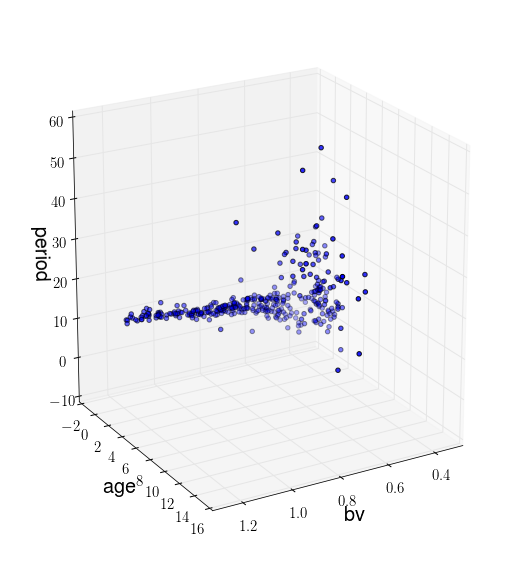

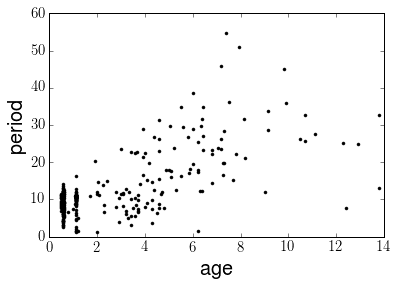

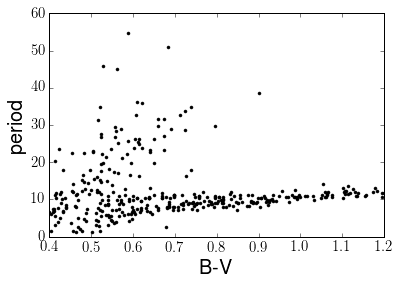

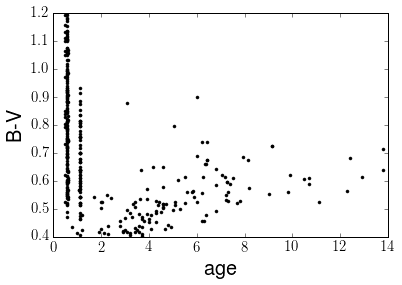

In [4]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(bv, age, period)
ax.set_xlabel("bv")
ax.set_ylabel("age")
ax.set_zlabel("period")
ax.view_init(20, 60)
plt.show()

plt.plot(age, period, "k.")
plt.xlabel("age")
plt.ylabel("period")
plt.show()

plt.plot(bv, period, "k.")
plt.xlabel("B-V")
plt.ylabel("period")
plt.show()

plt.plot(age, bv, "k.")
plt.xlabel("age")
plt.ylabel("B-V")
plt.show()

In [5]:
# set your x, y z and hyperparameters
D = np.vstack((bv, period)).T
A, lbv, lp, sigma = 10, 2000, 50, 1.

# GP prediction
k = A**2 * ExpSquaredKernel([lbv**2, lp**2], ndim=2)
gp = george.GP(k)
gp.compute(D, (age_err**2+sigma**2)**.5)

xs = np.zeros((1, 2))
xs[0, 0] = .65
xs[0, 1] = 26

mu, cov = gp.predict(age, xs)  # do the prediction
v = np.diag(cov)**.5
print(mu, "+/-", v)

[ 5.32544163] +/- [ 0.18666719]


Plot prediction for age vs period.

In [6]:
def plot_2d_prediction(x, y, xerr, yerr, mu, v, xs, theta, xlabel, ylabel):
    
    plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt="k.")
    plt.errorbar(xs, mu, yerr=v, fmt="r.", ms=10)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    xplot = np.linspace(min(x), max(x), 100)
    k = theta[0]**2 * ExpSquaredKernel(theta[1]**2)
    gp = george.GP(k)
    gp.compute(x, (yerr**2+sigma**2)**.5)
    mus, covs = gp.predict(y, xplot)  # do the prediction
    vs = np.diag(covs)**.5
    plt.plot(xplot, mus)
    plt.fill_between(xplot, mus-vs, mus+vs, alpha=.2)

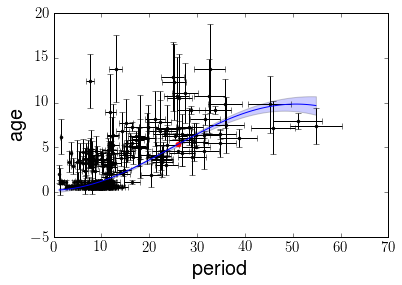

In [7]:
plot_2d_prediction(period, age, period_err, age_err, mu, v, xs[0, 1], [A, lp, sigma], "period", "age")

Plot prediction for age vs color.

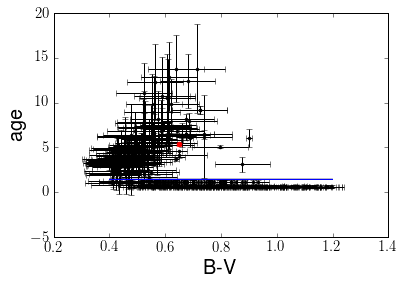

In [8]:
plot_2d_prediction(bv, age, bv_err, age_err, mu, v, xs[0, 0], [A, lbv, sigma], "B-V", "age")

Now perform MCMC.

Define the age model.

In [9]:
def gyro_age(pars, period, bv, barnes=False):
    """
    Calculates an age from a rotation period and colour.
    Parameters
    ----------
    pars: array or list
        gyrochronology parameters [a, b, n]
        barnes params are a, b, c, n = .7725, .601, .4, .5189
    period : array_like[nsamples]
        Rotation period in days.
    bv: array_like[nsamples]
        B-V color.
    Returns:
        Age in Gyr.
    """
    a, b, n = pars
    return (period / a * (bv - .4) ** b) ** n

Define initial parameters, prior, likelihood function and log prob.

In [10]:
theta_init = np.log(np.array([A, lbv, lp, sigma]))  # initial guess

In [11]:
def lnprior(theta):  # very broad uniform log prior
    if -20 < theta[0] < 20 and 0 < theta[1] < 20 and 0 < theta[2] < 20 and -20 < theta[3] < 20:
        return 0.
    return -np.inf

In [12]:
def lnlike(theta, x, y, z, yerr, mean_model=True):
    theta = np.exp(theta)
    D = np.vstack((x, z)).T
    k = theta[0]**2 * ExpSquaredKernel([theta[1]**2, theta[2]**2], ndim=2)
    gp = george.GP(k)
    try:
        gp.compute(D, (yerr**2 + theta[3]**2)**.5)
    except (ValueError, np.linalg.LinAlgError):
        return 10e25
    if mean_model:
        r = y - bn.age(z, x)
        m = np.isfinite(r)
        if len(r) > len(r[m]):
            return -np.inf
        return gp.lnlikelihood(r, quiet=True)
    return gp.lnlikelihood(y, quiet=True)

In [13]:
def lnprob(theta, x, y, z, yerr):
    return lnlike(theta, x, y, z, yerr) + lnprior(theta)

Set up MCMC.

In [14]:
x, y, z, yerr = bv, age, period, age_err
burnin, nwalkers, ndim = 1000, 24, len(theta_init)
runs = np.zeros(5) + 1000
p0 = [theta_init+1e-4*np.random.rand(ndim) for i in range(nwalkers)]
args = (x, y, z, yerr)

Time the lhf call.

In [15]:
start = time.time()
print("lnprob = ", lnprob(theta_init, x, y, z, yerr))
end = time.time()
tm = end - start
print("1 lhf call takes ", tm, "seconds")
print("burn in will take", tm * nwalkers * burnin, "s")
print("each run will take", tm * nwalkers * sum(runs)/60, "mins")
print("total = ", (tm * nwalkers * sum(runs) + tm * nwalkers * burnin)/60, "mins")

lnprob =  -796.02894204
1 lhf call takes  0.00764918327331543 seconds
burn in will take 183.5803985595703 s
each run will take 15.2983665466 mins
total =  18.358039856 mins


Run the MCMC.

burning in..., 1000 steps


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


production run, 1000 steps
time taken =  2.931208582719167 minutes


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



 0.352889354742 period (days) 

[ 4.10520303  0.04775918  3.12174348 -1.04160071]
Plotting traces
Making triangle plot
plotting prediction
production run, 1000 steps
time taken =  2.865904152393341 minutes


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



 0.352108729962 period (days) 

[ 4.09703605  0.0444114   3.11495842 -1.04381526]
Plotting traces
Making triangle plot
plotting prediction
production run, 1000 steps
time taken =  2.681244699160258 minutes

 0.352327323858 period (days) 

[ 4.09192644  0.04477613  3.11755983 -1.04319464]
Plotting traces
Making triangle plot
plotting prediction
production run, 1000 steps
time taken =  2.985724846522013 minutes

 0.351787894908 period (days) 

[ 4.10132605  0.04493445  3.11739057 -1.04472686]
Plotting traces
Making triangle plot
plotting prediction
production run, 1000 steps
time taken =  3.004988169670105 minutes

 0.352433315111 period (days) 

[ 4.09673791  0.04542308  3.1157737  -1.04289385]
Plotting traces
Making triangle plot
plotting prediction


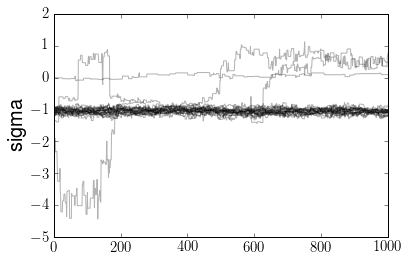

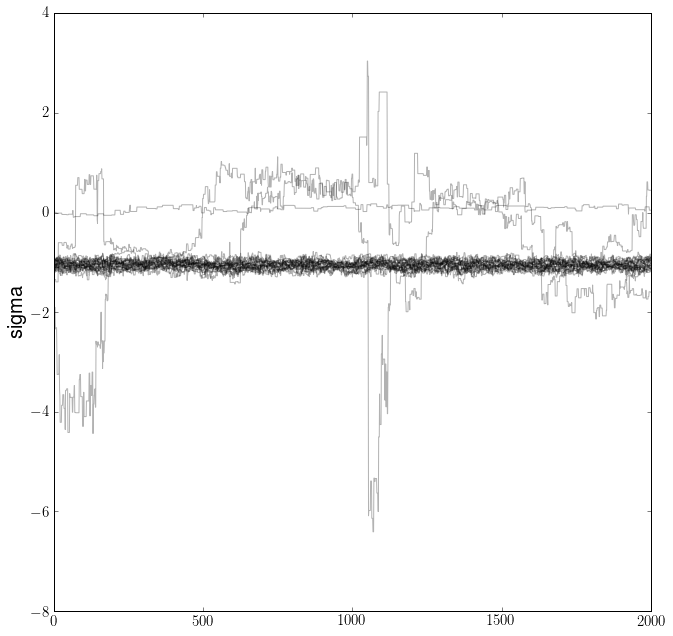

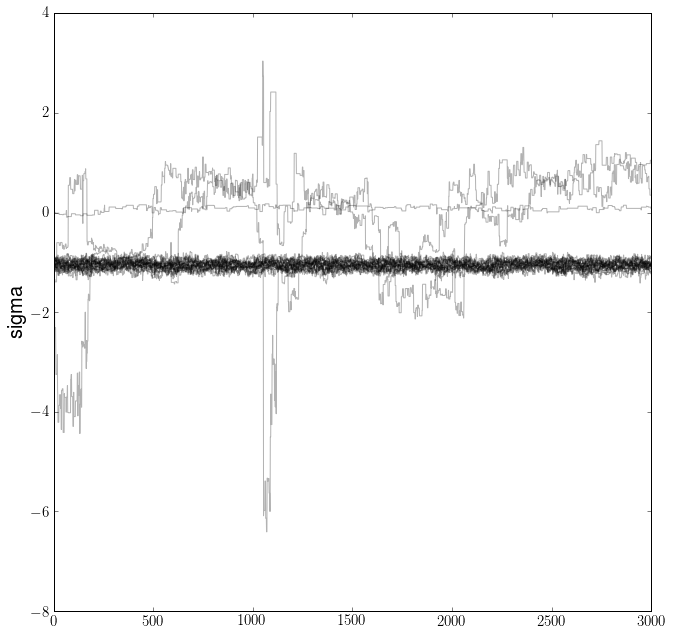

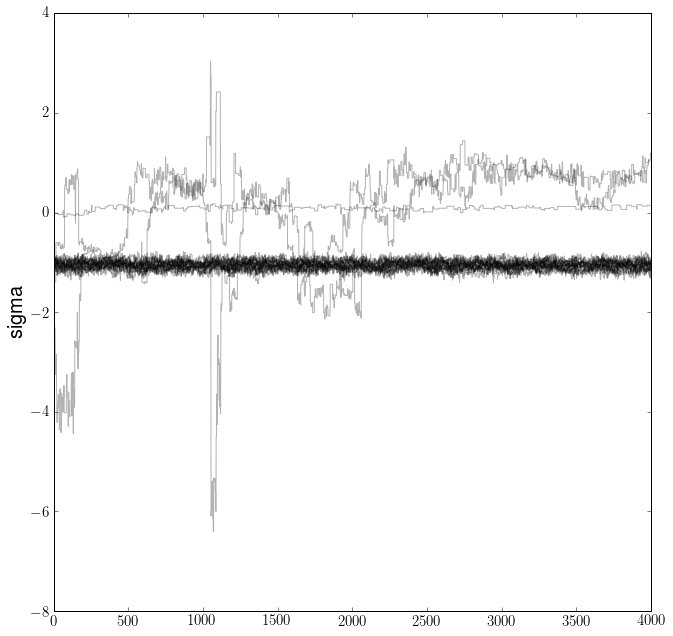

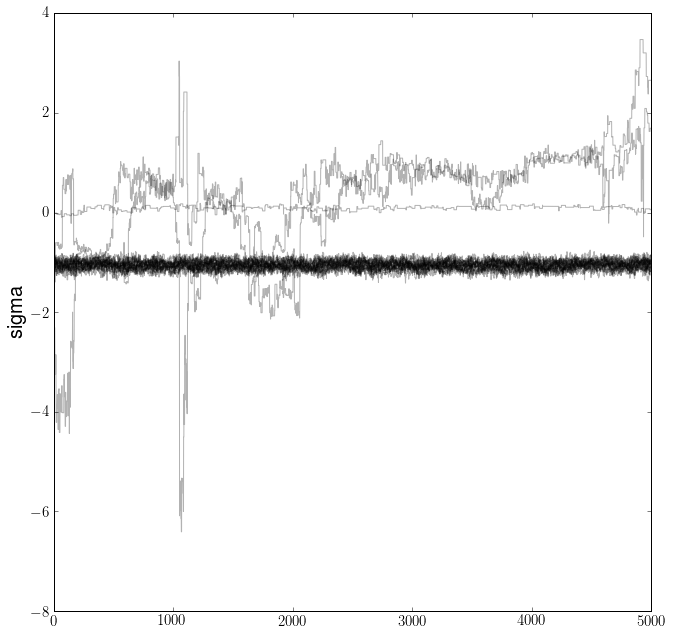

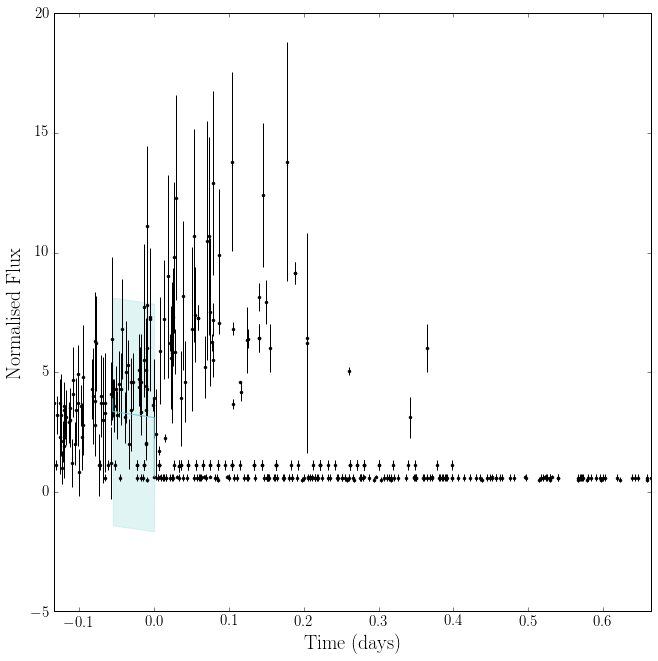

In [16]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)
print("burning in..., {0} steps".format(int(burnin)))
p0, _, state = sampler.run_mcmc(p0, burnin)
fig_labels = ["A", "lbv", "lp", "sigma"]

sample_array = np.zeros((nwalkers, sum(runs), ndim))
for i, run in enumerate(runs):
    sampler.reset()
    print("production run, {0} steps".format(int(run)))
    start = time.time()
    p0, _, state = sampler.run_mcmc(p0, run)
    end = time.time()
    print("time taken = ", (end - start)/60, "minutes")
    
    # save samples
    sample_array[:, sum(runs[:i]):sum(runs[:(i+1)]), :] = np.array(sampler.chain)
    f = h5py.File(os.path.join(RESULTS_DIR, "3Dsamples.h5"), "w")
    data = f.create_dataset("samples", np.shape(sample_array))
    data[:, :] = sample_array
    f.close()
    
    # make plots at increments
    mcmc_result = make_plot(sample_array[:, :sum(runs[:(i+1)]), :], x, y, yerr, fig_labels, "3D", 
                            RESULTS_DIR, traces=True, tri=True, prediction=True)

Calculate the age of the Sun.

In [19]:
def age_model(mybv, myperiod, plot=False, barnes=True):
    """
    Given a rotation period and a colour, calculate the age.
    """
    
    # load the data for conditioning...
    age, age_err, bv, bv_err, period, period_err, logg, feh = load_data()
    
    # load the results
    with h5py.File(os.path.join(RESULTS_DIR, "3Dsamples.h5"), "r") as f:
            samples = f["samples"][...]
    nwalkers, nsteps, ndims = np.shape(samples)
    flat = np.reshape(samples, (nwalkers * nsteps, ndims))
    mcmc_result = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                      zip(*np.percentile(flat, [16, 50, 84], axis=0)))
    theta = np.exp(np.array([i[0] for i in mcmc_result]))

    A, lbv, lp, sigma = theta
        
    D = np.vstack((bv, period)).T
    k = A**2 * ExpSquaredKernel([lbv**2, lp**2], ndim=2)
    gp = george.GP(k)
    gp.compute(D, (age_err**2 + sigma**2)**.5)
    xs = np.zeros((1, 2))
    xs[0, 0] = mybv
    xs[0, 1] = myperiod
    mu, cov = gp.predict(age-bn.age(period, bv), xs)  # do the GP prediction
    #mu, cov = gp.predict(age, xs)  # do the GP prediction
    v = np.diag(cov)**.5
    mu += bn.age(myperiod, mybv)
    
    if plot:
        
        m = (myperiod - 10 < period) * (period < myperiod + 10)
        plt.errorbar(bv[m], age[m], xerr=bv_err[m], yerr=age_err[m], fmt="k.")
        plt.errorbar(mybv, mu, yerr=v, fmt="r.", ms=10)
        plt.xlabel("B-V")
        plt.ylabel("age")        
        xplot = np.linspace(min(bv[m]), max(bv[m]), 100)
        k = A**2 * ExpSquaredKernel(lbv**2)
        gp = george.GP(k)
        
        # Compute the prediction conditioned on the observations and plot it.
        gp.compute(bv[m], (age_err[m]**2 + sigma**2)**.5)
        #mus, covs = gp.predict(age[m], xplot)  # do the prediction
        mus, covs = gp.predict(age[m] - bn.age(myperiod, bv[m]), xplot)  # do the prediction
        vs = np.diag(covs)**.5
        plt.plot(xplot, mus + bn.age(myperiod, xplot), label=("period = {0}".format(myperiod)))
        plt.fill_between(xplot, mus + bn.age(myperiod, xplot) - vs - sigma,
                         mus + bn.age(myperiod, xplot) + vs + sigma, alpha=.2)
        #plt.plot(xplot, mus, label=("period = {0}".format(myperiod)))
        #plt.fill_between(xplot, mus - vs - sigma, mus + vs + sigma, alpha=.2)
        plt.legend(loc="best")
        plt.show()

        m = (mybv - .1 < bv) * (bv < mybv + .1)
        plt.errorbar(period[m], age[m], xerr=period_err[m], yerr=age_err[m], fmt="k.")
        plt.errorbar(myperiod, mu, yerr=v, fmt="r.", ms=10)
        plt.xlabel("period")
        plt.ylabel("age")
        xplot = np.linspace(min(period[m]), max(period[m]), 100)
        k = A**2 * ExpSquaredKernel(lp**2)
        gp = george.GP(k)
        gp.compute(period[m], (age_err[m]**2 + sigma**2)**.5)
        mus, covs = gp.predict(age[m] - bn.age(period[m], mybv), xplot)  # do the prediction
        #mus, covs = gp.predict(age[m], xplot)  # do the prediction
        vs = np.diag(covs)**.5
        #plt.plot(xplot, mus, label=("B-V = {0}".format(mybv)))
        #plt.fill_between(xplot, mus - vs - sigma, mus + vs + sigma, alpha=.2)
        plt.plot(xplot, mus + bn.age(xplot, mybv), label=("B-V = {0}".format(mybv)))
        plt.fill_between(xplot, mus + bn.age(xplot, mybv) - vs - sigma,
                         mus + bn.age(xplot, mybv) + vs + sigma, alpha=.2)
        plt.legend(loc="best")
        plt.show()
    
    print(theta)
    print("Age = {0} +/- {1} Gyr".format(mu[0], v[0]+theta[3]))
    return mu, v

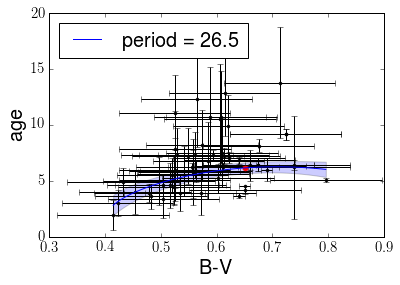

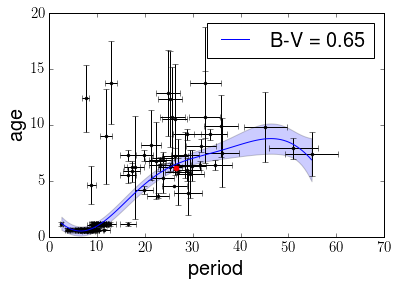

[ 60.14376994   1.04647051  22.55087071   0.3524333 ]
Age = 6.175388536480005 +/- 0.5037289791124363 Gyr


In [20]:
age = age_model(.65, 26.5, plot=True)

In [18]:
print(theta)

NameError: name 'theta' is not defined